In [2]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation

from neuralprophet import NeuralProphet, set_log_level

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


Test train split.

In [12]:
def fit_prophet(df):
    m = Prophet()
    m.fit(df)

    # create forecast
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)

    # create plots
    pred_plot = plot_plotly(m, forecast)
    comp_plot = plot_components_plotly(m, forecast)

    return (m, forecast, pred_plot, comp_plot)

def eval_prophet(m):

    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

    return (df_cv, performance_metrics(df_cv))

In [15]:
def fit_neural(df, params=None):
    """
    FIt NeuralProphet and return key objects.
    """

    # fit 
    m = NeuralProphet(**params) if params is not None else NeuralProphet()
    metrics = m.fit(df, freq="D")

    df_future = m.make_future_dataframe(df, periods=365)
    forecast = m.predict(df_future, raw=True, decompose=False) if params is not None else m.predict(df_future)

    if params is None:
        fig_forecast = m.plot(forecast)
        fig_components = m.plot_components(forecast)
        fig_params = m.plot_parameters()

        return (m, forecast, fig_forecast, fig_components, fig_params) 

    else:
        return (None, forecast, None, None)

def eval_neural(df):
    """
    Perform cross validation on our model.
    IMPORTANT: this is correct eval method according to the docs, but differs from Prophet 
               so I built a custom function.
    """

    # setup k fold CV
    METRICS = ['SmoothL1Loss', 'MAE', 'RMSE']

    folds = NeuralProphet().crossvalidation_split_df(df, freq="D", k=5, fold_pct=0.20, fold_overlap_pct=0.5)

    # return dfs
    metrics_train = pd.DataFrame(columns=METRICS)
    metrics_test = pd.DataFrame(columns=METRICS)

    # CV
    for df_train, df_test in folds:
        m = NeuralProphet()
        train = m.fit(df=df_train, freq="D")
        test = m.test(df=df_test)
        metrics_train = metrics_train.append(train[METRICS].iloc[-1])
        metrics_test = metrics_test.append(test[METRICS].iloc[-1])

    return (metrics_train, metrics_test)

In [13]:
m1, forecast1, forecast_plot1, component_plot1 = fit_prophet(df)
cv_df, prophet_accuracy_df = eval_prophet(m1)
# show plots
forecast_plot1.show()
component_plot1.show()
print(prophet_accuracy_df.describe())

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


  0%|          | 0/11 [00:00<?, ?it/s]

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


                          horizon         mse        rmse         mae  \
count                         329  329.000000  329.000000  329.000000   
mean            201 days 00:00:00    0.645536    0.797941    0.617272   
std    95 days 02:50:25.209861311    0.155662    0.094087    0.085259   
min              37 days 00:00:00    0.415610    0.644678    0.489996   
25%             119 days 00:00:00    0.529438    0.727625    0.539194   
50%             201 days 00:00:00    0.600038    0.774621    0.615669   
75%             283 days 00:00:00    0.764304    0.874245    0.674681   
max             365 days 00:00:00    1.188329    1.090105    0.888305   

             mape       mdape       smape    coverage  
count  329.000000  329.000000  329.000000  329.000000  
mean     0.074485    0.061169    0.074037    0.591674  
std      0.010421    0.011099    0.010443    0.053762  
min      0.058538    0.041675    0.058826    0.471220  
25%      0.065355    0.052865    0.064689    0.544084  
50%   

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 59 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 59 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142
Epoch[142/142]: 100%|██████████| 142/142 [00:23<00:00,  6.00it/s, SmoothL1Loss=0.0033, MAE=0.248, RMSE=0.354, RegLoss=0.000535] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Define

  0%|          | 0/127 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.28E-01


  0%|          | 0/127 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.48E-02, min: 1.18E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.47E-02
Epoch[185/185]: 100%|██████████| 185/185 [00:11<00:00, 15.73it/s, SmoothL1Loss=0.00497, MAE=0.289, RMSE=0.402, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.139% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.038  0.899  1.147
WARNING - (py.warnings._showwarnmsg) - /var/folders/62/rh1j1kw97dq2zkd4v2dskzw80000gn/T/ipykernel_32928/3324044098.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


WARNING - (py.warnings._showwarnmsg) - /var/folders/62/rh1j1kw97dq2zkd4v2dskzw80000gn/T/ipykernel_32928/3324044098.py:47: FutureWarning:

  0%|          | 0/129 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.11E-01, min: 4.78E-01


  0%|          | 0/129 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.06E-02, min: 6.61E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.65E-02
Epoch[173/173]: 100%|██████████| 173/173 [00:12<00:00, 13.83it/s, SmoothL1Loss=0.00504, MAE=0.302, RMSE=0.415, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.484% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.025  0.772  0.959
WARNING - (py.warnings._showwarnmsg) - /var/folders/62/rh1j1kw97dq2zkd4v2dskzw80000gn/T/ipykernel_32928/3324044098.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


WARNING - (py.warnings._showwarnmsg) - /var/folders/62/rh1j1kw97dq2zkd4v2dskzw80000gn/T/ipykernel_32928/3324044098.py:47: FutureWarning:

  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 2.34E-01


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 1.35E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.04E-01
Epoch[164/164]: 100%|██████████| 164/164 [00:15<00:00, 10.51it/s, SmoothL1Loss=0.00569, MAE=0.337, RMSE=0.467, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.484% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.025  0.877  0.996
WARNING - (py.warnings._showwarnmsg) - /var/folders/62/rh1j1kw97dq2zkd4v2dskzw80000gn/T/ipykernel_32928/3324044098.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


WARNING - (py.warnings._showwarnmsg) - /var/folders/62/rh1j1kw97dq2zkd4v2dskzw80000gn/T/ipykernel_32928/3324044098.py:47: FutureWarning:

  0%|          | 0/133 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.31E-02, min: 1.97E+00


  0%|          | 0/133 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.31E-02, min: 1.69E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.11E-02
Epoch[157/157]: 100%|██████████| 157/157 [00:17<00:00,  9.13it/s, SmoothL1Loss=0.00565, MAE=0.331, RMSE=0.464, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.312% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.016  0.604  0.803
WARNING - (py.warnings._showwarnmsg) - /var/folders/62/rh1j1kw97dq2zkd4v2dskzw80000gn/T/ipykernel_32928/3324044098.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


WARNING - (py.warnings._showwarnmsg) - /var/folders/62/rh1j1kw97dq2zkd4v2dskzw80000gn/T/ipykernel_32928/3324044098.py:47: FutureWarning:

  0%|          | 0/134 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 1.27E+00


  0%|          | 0/134 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 7.98E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.04E-01
Epoch[151/151]: 100%|██████████| 151/151 [00:18<00:00,  8.13it/s, SmoothL1Loss=0.00595, MAE=0.353, RMSE=0.488, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.312% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.015  0.680  0.787
WARNING - (py.warnings._showwarnmsg) - /var/folders/62/rh1j1kw97dq2zkd4v2dskzw80000gn/T/ipykernel_32928/3324044098.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


WARNING - (py.warnings._showwarnmsg) - /var/folders/62/rh1j1kw97dq2zkd4v2dskzw80000gn/T/ipykernel_32928/3324044098.py:47: FutureWarning:

       SmoothL1Loss       MAE      RMSE
count      5.000000  5.000000  5.000000
mean       0.005461  0.322355  0.447081
std        0.000433  0.026416  0.036971
min        0.004968  0.288615  0.401896
25%        0.005040  0.301742  0.414513
50%        0.005652  0.331262  0.463860
75%        0.005695  0.337462  0.466973
max        0.005949  0.352693  0.488164
       SmoothL1Loss       MAE      RMSE
count      5.000000  5.000000  5.000000
mean       0.023788  0.766350  0.938334
std        0.009428  0.126044  0.149009
min        0.014709  0.603978  0.786735
25%        0.016077  0.680386  0.802630
50%        0.024525  0.771678  0.958641
75%        0.025325  0.876919  0.996464
max        0.038305  0.898787  1.147202


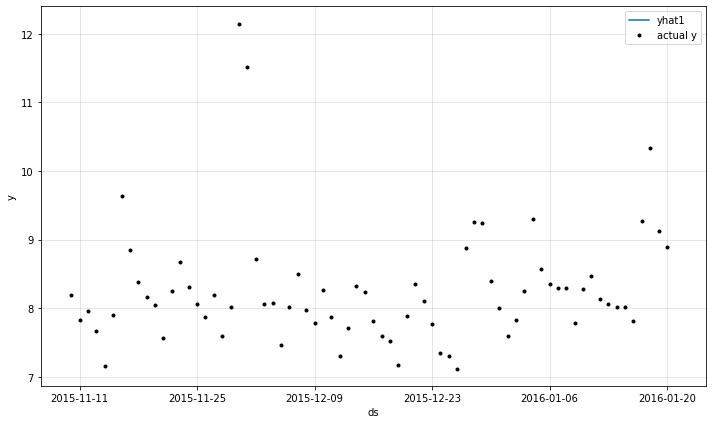

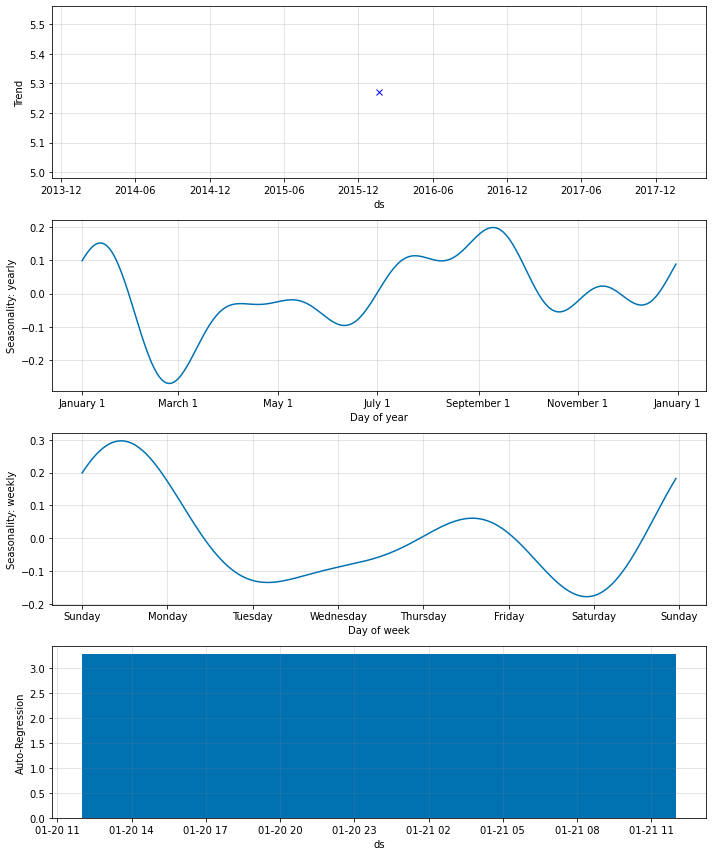

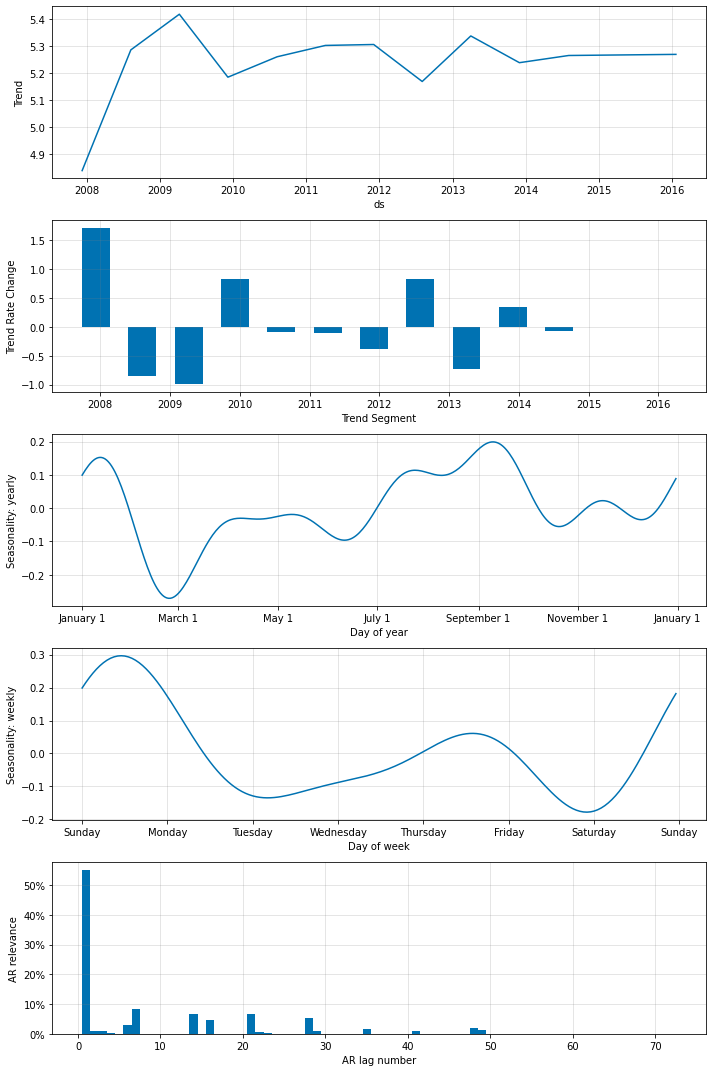

In [16]:
m2, forecast2, forecast_plot2, component_plot2, params_plot2 = fit_neural(df)
metrics_train, metrics_test = eval_neural(df)
print(metrics_train.describe())
print(metrics_test.describe())
plt.show()

In [19]:
def accuracy(obs, pred):
    """
    Calculate accuracy measures
    :param obs: pd.Series of observed values
    :param pred: pd.Series of forecasted values
    :return: dict with accuracy measures
    """

    obs, pred = np.array(obs.dropna()), np.array(pred.dropna())

    assert len(obs) == len(pred), f'accuracy(): obs len is {len(obs)} but preds len is {len(pred)}'

    rmse = np.sqrt(np.mean((obs - pred)**2))
    mape = np.mean(np.abs((obs - pred) / obs)) 

    return (rmse, mape)

def cv_run_both_models(df, neural_params):
    """
    Create a CV dataset and run both models and return accuracies. Note that both models
    have their own eval methods, but they differ so I built a custom func that does the 
    same thing. 
    :param df: pd.DataFrame of Prophet-specified format
    :param neural_params: dict of params to be passed to NeuralProphet
    :return: tuple of training accuracies
    """

    # create train test splits (test = 365 days, train = all prior data, increment = 180 days)
    train_test_split_indices = list(range(365*2, len(df.index) - 365, 180))
    train_test_splits = [(df.iloc[:i, :], df.iloc[i:(i+365), :]) for i in train_test_split_indices]

    rmse_p, mape_p = [], []
    rmse_n, mape_n = [], []
    n_training_days = []

    # loop through train/test splits
    for x in train_test_splits:
        train, test = x
        n_training_days.append(len(train.index))

        # train Prophet and get accuracy 
        _, forecast, *_ = fit_prophet(train)
        rmse, mape = accuracy(test['y'], forecast.loc[test['y'].index, 'yhat'])
        rmse_p.append(rmse)
        mape_p.append(mape)

        # train NeuralProphet and get accuracy 
        _, forecast, *_ = fit_neural(train, neural_params)
        rmse, mape = accuracy(test['y'], pd.Series(np.array(forecast.iloc[:, 1:]).flatten()))
        rmse_n.append(rmse)
        mape_n.append(mape)

    return pd.DataFrame(dict(
        n_training_days=n_training_days,
        prophet_RMSE=rmse_p,
        neural_RMSE=rmse_n,
        prophet_MAPE=mape_p,
        neural_MAPE=mape_n
    ))
